# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Create datasets
train_set = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train=True,
                                      download=True, transform=transform)
test_set = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train=False,
                                      download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])


# Define data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing


I have applied data normalization and flattening as preprocessing steps to prepare the MNIST dataset for training. I did not perform explicit one-hot encoding because PyTorch takes care of it automatically.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
train_data = train_set.dataset.data[train_set.indices]
train_labels = train_set.dataset.targets[train_set.indices]
print("Training Data:")
print("Size:", len(train_data))
print("Shape:", train_data.shape)
print("Label Size:", len(train_labels))
print("Label Shape:", train_labels.shape)

val_data = val_set.dataset.data[val_set.indices]
val_labels = val_set.dataset.targets[val_set.indices]
print("\nValidation Data:")
print("Size:", len(val_data))
print("Shape:", val_data.shape)
print("Label Size:", len(val_labels))
print("Label Shape:", val_labels.shape)

test_data = test_set.data
test_labels = test_set.targets
print("\nTest Data:")
print("Size:", len(test_data))
print("Shape:", test_data.shape)
print("Label Size:", len(test_labels))
print("Label Shape:", test_labels.shape)




Training Data:
Size: 48000
Shape: torch.Size([48000, 28, 28])
Label Size: 48000
Label Shape: torch.Size([48000])

Validation Data:
Size: 12000
Shape: torch.Size([12000, 28, 28])
Label Size: 12000
Label Shape: torch.Size([12000])

Test Data:
Size: 10000
Shape: torch.Size([10000, 28, 28])
Label Size: 10000
Label Shape: torch.Size([10000])


In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


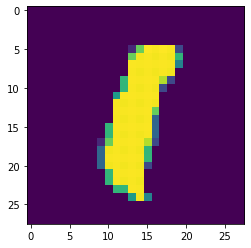

7


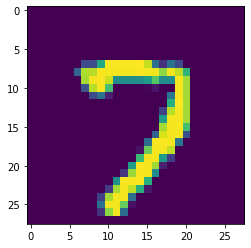

9


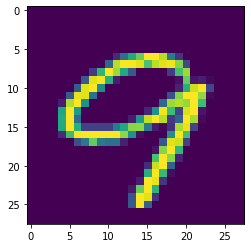

2


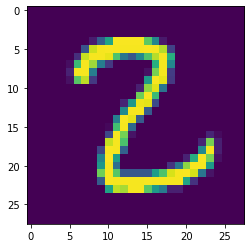

3


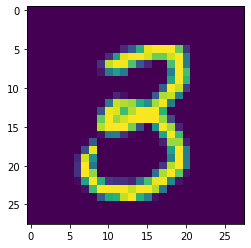

In [7]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = nn.LogSoftmax(dim=1)
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Model1()
model.to(device)


Model1(
  (output): LogSoftmax(dim=1)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=12):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        model.train()  # Set the model to training mode

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            train_correct += torch.eq(preds, labels).sum().item()
            train_loss += loss.item()

        train_accuracy =100*train_correct / len(train_loader.dataset)
        train_loss_avg = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.5f}, Training Loss: {train_loss_avg:.5f}")



        train_loss_history.append(train_loss_avg)
        train_acc_history.append(train_accuracy)

        val_loss = 0.0
        val_correct = 0
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                val_correct += torch.eq(preds, labels).sum().item()
                val_loss += loss.item()

        val_accuracy = 100*val_correct / len(val_loader.dataset)
        val_loss_avg = val_loss / len(val_loader)
        val_loss_history.append(val_loss_avg)
        val_acc_history.append(val_accuracy)
        print(f"Epoch {epoch + 1} - Validation Accuracy: {val_accuracy:.5f}, Validation Loss: {val_loss_avg:.5f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, model




In [ ]:
# training the model
num_epochs = 6
train_loss_history, val_loss_history, train_acc_history, val_acc_history, trained_model = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)



Epoch 1 - Training Accuracy: 81.33542, Training Loss: 0.00921
Epoch 1 - Validation Accuracy: 90.42500, Validation Loss: 0.29350
Epoch 2 - Training Accuracy: 90.15833, Training Loss: 0.00513
Epoch 2 - Validation Accuracy: 93.90833, Validation Loss: 0.20156
Epoch 3 - Training Accuracy: 91.48333, Training Loss: 0.00440
Epoch 3 - Validation Accuracy: 94.69167, Validation Loss: 0.18374
Epoch 4 - Training Accuracy: 92.30417, Training Loss: 0.00394
Epoch 4 - Validation Accuracy: 95.07500, Validation Loss: 0.16265
Epoch 5 - Training Accuracy: 93.08125, Training Loss: 0.00360
Epoch 5 - Validation Accuracy: 95.28333, Validation Loss: 0.15432


Plot the training loss (and validation loss/accuracy, if recorded).

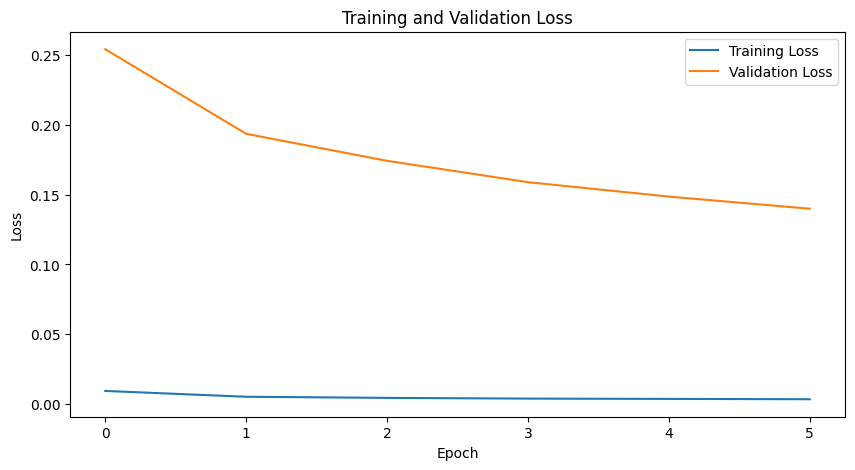

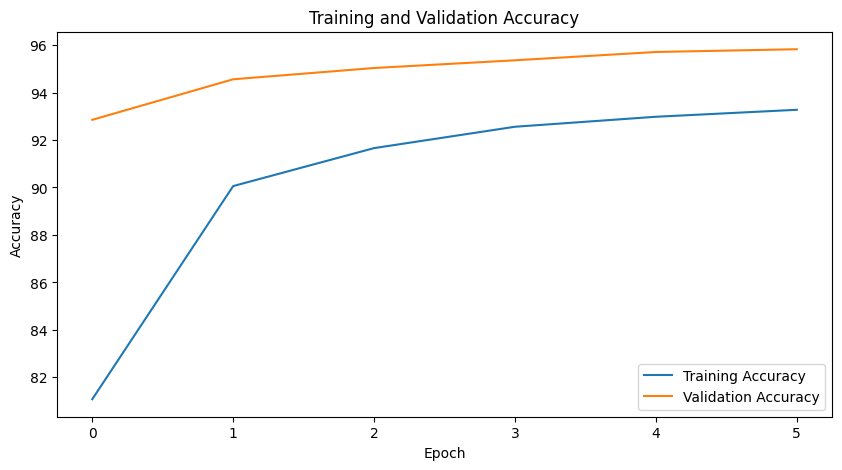

In [12]:

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.29%


In [20]:
def visualize_probabilities(model, image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        image = image.to(device)  # Move the image tensor to the same device as the model
        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0]  # Apply softmax to obtain probabilities
        classes = range(10)  # Assuming there are 10 classes in the dataset

        # Plot the image
        plt.imshow(image.squeeze().cpu(), cmap='gray')  # Move the image tensor to CPU for plotting
        plt.title('Image')
        plt.axis('off')
        plt.show()

        # Plot the probabilities
        plt.bar(classes, probabilities.cpu())  # Move the probabilities tensor to CPU for plotting
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title('Class Probabilities')
        plt.xticks(classes)
        plt.show()




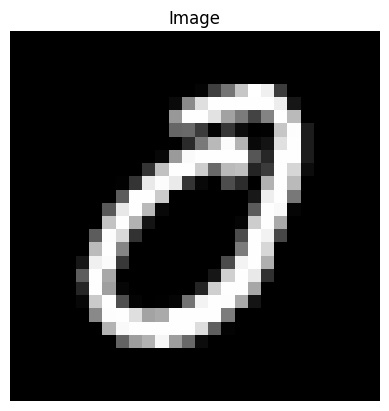

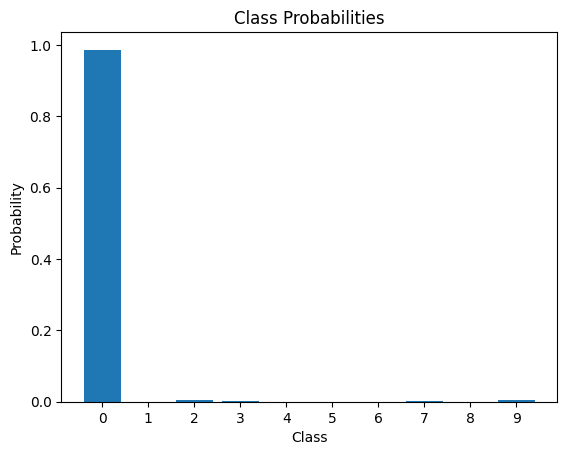

In [22]:
# Getting the image to test
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
# Flatten the image to pass in the model
img = images[0].view(1, 28, 28)
visualize_probabilities(model, img)




## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

## Saving your model
Using `torch.save`, save your model for future loading.

In [23]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth')
